This model is based on (https://github.com/dennybritz/reinforcement-learning).

On this case, we apply Qlearning method on Gridword environment Sutton & Barto(2018)p130.

In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys


if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = WindyGridworldEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, stats

In [5]:
Q, stats = q_learning(env, 300)

Episode 300/300.

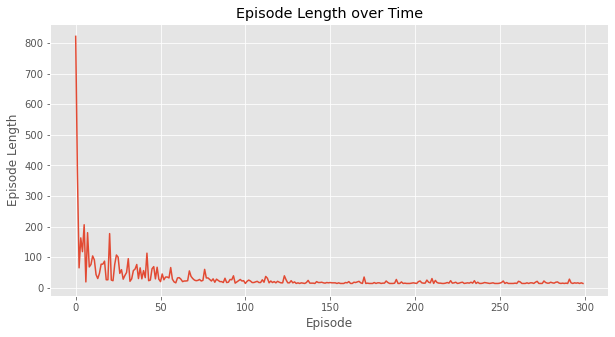

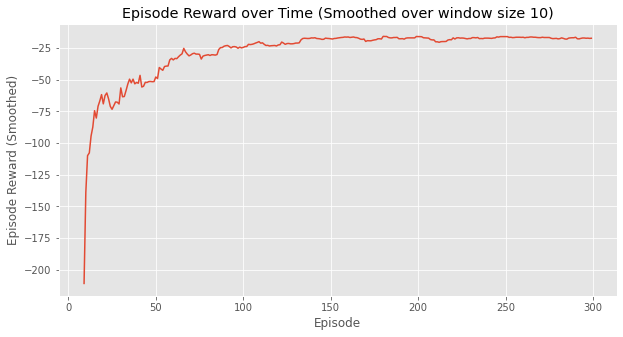

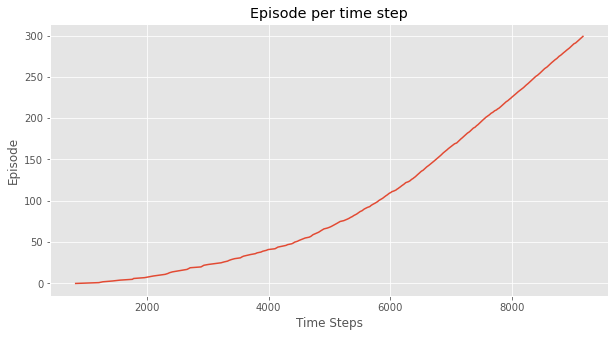

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [6]:
plotting.plot_episode_stats(stats)

In [7]:
print(env.step(2))
env.render()
print(env.step(1))
env.render()

(27, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

(8, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



In [8]:
print("State  "+ "Action[Up Right Down Left]")
print("---------------------------------------")
for q in Q:
    print(str(q) +" "+str(Q[q]))

State  Action[Up Right Down Left]
---------------------------------------
30 [-15.71180278 -15.         -15.2974188  -15.94447607]
20 [-14.86549195 -14.89168636 -15.1049938  -14.93216944]
10 [-14.20969727 -14.32773282 -14.26774582 -14.20960769]
0 [-13.73846717 -13.81491139 -14.05755302 -13.82757427]
1 [-13.79870872 -13.59270449 -14.02635023 -13.59451876]
2 [-13.24352317 -12.89211283 -13.24758984 -13.66689154]
3 [-12.37389574 -11.99903911 -12.28245597 -12.52507256]
4 [-11.9017956  -11.         -11.64180927 -12.60928803]
5 [-10.91125182 -10.         -10.5        -11.88242348]
6 [ -9.99606926  -9.          -9.99726997 -10.99479505]
7 [-8.99867884 -8.         -8.99542999 -9.95862451]
8 [-7.9976663  -7.         -7.99986156 -8.99186462]
9 [-6.99975479 -6.99952939 -6.         -7.99190013]
19 [-6.98770794 -5.99536628 -5.         -7.70281102]
29 [-5.99895523 -4.97991426 -4.         -6.33153239]
18 [-7.45644832 -6.96486091 -7.42972182 -7.44591957]
39 [-4.99892758 -3.99757831 -3.         -5.71880